In [29]:
import sympy as sm
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# models
from modelproject import Solow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We define the solow model with human capital from the listed equations, following standard notation.

$$
\begin{align}
    Y_t & = K_t^{\alpha} H_t^{\phi} (A_tL_t)^{1-\alpha-\phi}, &0<α,φ<1\\
    S_t & = (s_k + s_H) Y_t, &s_k + s_H < 1 \\
    C_t &= Y_t-S_t = (1-s_K-s_H)Y_t \\
    K_{t+1} &= s_K Y_t + (1-\delta)K_t \\
    H_{t+1} &= s_H Y_T + (1-\delta)H_t \\
    L_{t+1} &= (1+n) L_t \\
    A_{t+1} &= (1+g) L_t.
\end{align}
$$

We define the tilde transformation of $X_t$ as
$$
\begin{aligned}
    \tilde{X}_t & \equiv X_t/(A_tL_t) \\
\end{aligned}
$$

Using this transformation, we can rewrite the transitions equation for fysical capital (4) and human capital (5), as

$$
\begin{aligned}

    \tilde{k}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_K \tilde{k}_t^{\alpha} \tilde{h}_t^{\phi} + (1-\delta) \tilde{k}_t),\\
    
    \tilde{h}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_H \tilde{h}_t^{\alpha} \tilde{h}_t^{\phi} + (1-\delta) \tilde{h}_t).\\

\end{aligned}
$$

We derive the nullclines using sympy

In [30]:
# a. define symbols 
k_tilde, h_tilde = sm.symbols('ktilde_t, htilde_t')
sK, sH = sm.symbols('s_K, s_H')
g, n  = sm.symbols('g, n')
delta, alpha, phi = sm.symbols('delta, alpha, phi')

# b. define transistion equations
trans_k = sm.Eq(k_tilde, 
                1/((1+n)*(1+g))*(sK*k_tilde**alpha*h_tilde**phi+(1-delta)*k_tilde))
trans_h = sm.Eq(h_tilde, 
                1/((1+n)*(1+g))*(sH*k_tilde**alpha*h_tilde**phi+(1-delta)*h_tilde))

# c. derive nullclines from transition equations, isolate for h tilde 
# i. for no change in k tilde
no_change_k = sm.solve(trans_k,h_tilde)[0] 
null_k = sm.Eq(h_tilde, no_change_k)

# ii. for no change in h tilde
no_change_h = sm.solve(trans_h,h_tilde)[0]
null_h = sm.Eq(h_tilde, no_change_h)

# d. display nullclines 
print('no change in k tilde:')
display(null_k)
print('no change in h tilde:')
display(null_h)


no change in k tilde:


Eq(htilde_t, (ktilde_t**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/phi))

no change in h tilde:


Eq(htilde_t, ((delta + g*n + g + n)/(ktilde_t**alpha*s_H))**(1/(phi - 1)))

As we can see from the power of $\tilde{k}_t$, the nullcline for $\Delta \tilde{k}_t = 0$ and $\Delta \tilde{h}_t = 0$ is respectively convex and concave in the $\tilde{k}_t$-th dimension. We can explicitly show this by inserting values in the functions.

In [37]:
# a. lambdify nullclines 
null_k_func = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sK], no_change_k)
null_h_func = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sH], no_change_h)

# b. generate values 
# i. define values 
k_tilde_vec = np.linspace(0,3,100)

felix = Solow()
par = felix.par 

alpha_val = par.alpha
delta_val = par.delta
g_val = par.g
n_val = par.n
phi_val = par.phi
sK_val = 0.12
sH_val = 0.07

# ii. insert in lamdified nullclines
null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)


initialising the model
calling .setup()


<lambdifygenerated-22>:2: RuntimeWarning: divide by zero encountered in power
  return (ktilde_t**(-alpha)*(delta + g*n + g + n)/s_H)**((phi - 1)**(-1.0))


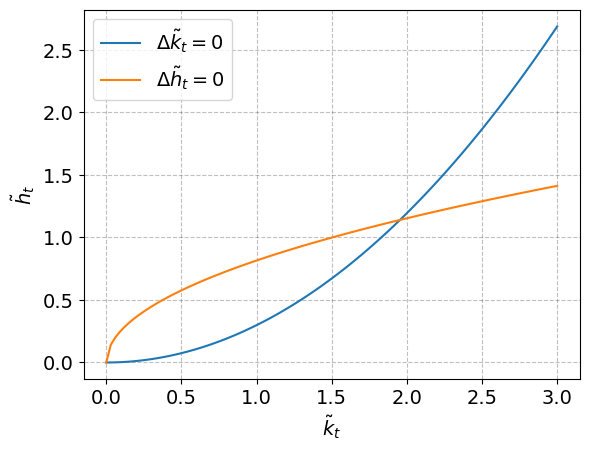

In [38]:
# c. plot results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$');
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$',)

ax.legend(loc='upper left');

In [55]:
# show convergence from simulation 
# a. do simulation 
# i. initialize model
felix = Solow()

# ii. change initial values (outside steady state)
par = felix.par 
par.A_init = 2
par.K_init = 10
par.H_init = 60
par.L_init = 2
par.Y_init = 2

# iii. extract simulation & unpack 
sim_out = felix.find_steady_state() 
k_t = sim_out.k_tilde
h_t = sim_out.h_tilde

# b. insert parameter values from simulation in nullclines  
# i. define values 
alpha_val = par.alpha
delta_val = par.delta
g_val = par.g
n_val = par.n
phi_val = par.phi
sK_val = sim_out.sK
sH_val = sim_out.sH

# ii. find range of k_tilde
k_tilde_vec = np.linspace(0, max(k_t) +1, 100)

# ii. insert in lamdified nullclines
null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)

initialising the model
calling .setup()


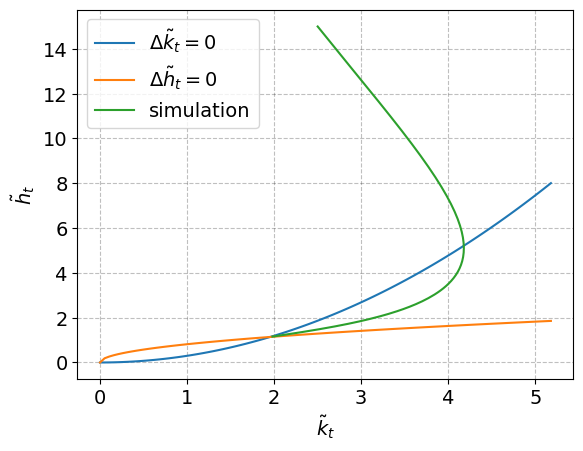

In [56]:
# c. plot results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(k_tilde_vec, null_k_val, label = r'$ \Delta \tilde{k}_t = 0$')
ax.plot(k_tilde_vec, null_h_val, label = r'$ \Delta \tilde{h}_t = 0$')
ax.plot(k_t, h_t, label='simulation')
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$',)

ax.legend(loc='upper left');

In [186]:
k_t

array([1.5       , 1.48122449, 1.46369966, 1.44732876, 1.43202329,
       1.41770224, 1.40429137, 1.39172264, 1.3799336 , 1.36886692,
       1.35846992, 1.34869419, 1.33949517, 1.33083187, 1.3226665 ,
       1.31496429, 1.30769312, 1.30082341, 1.29432782, 1.28818113,
       1.28236   , 1.27684289, 1.27160986, 1.26664246, 1.2619236 ,
       1.25743746, 1.25316938, 1.24910576, 1.24523399, 1.24154235,
       1.23801999, 1.2346568 , 1.23144339, 1.22837104, 1.22543161,
       1.22261755, 1.21992181, 1.21733782, 1.21485947, 1.21248104,
       1.2101972 , 1.20800296, 1.20589368, 1.20386499, 1.20191283,
       1.20003337, 1.19822305, 1.19647852, 1.19479662, 1.19317441,
       1.19160911, 1.19009812, 1.18863898, 1.1872294 , 1.18586719,
       1.1845503 , 1.1832768 , 1.18204487, 1.18085278, 1.17969891,
       1.1785817 , 1.1774997 , 1.17645153, 1.17543587, 1.17445148,
       1.17349718, 1.17257185, 1.17167442, 1.17080386, 1.16995923,
       1.16913959, 1.16834406, 1.16757181, 1.16682204, 1.16609

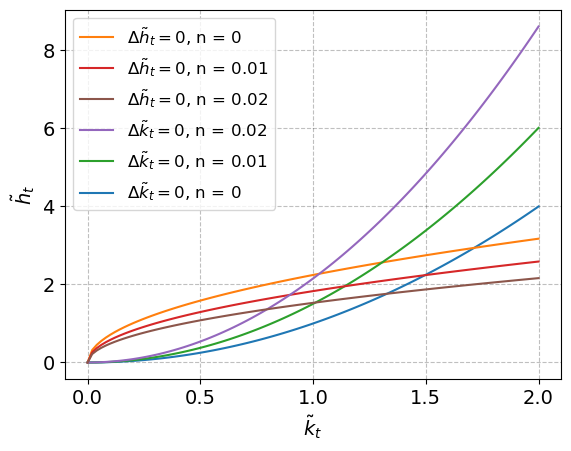

In [187]:
# plot results for different initial places:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)


# prepare loop 
label_k = r'$ \Delta \tilde{k}_t = 0$' # latex labels 
label_h = r'$ \Delta \tilde{h}_t = 0$'
n_lst=[0, 0.01, 0.02]

for n_val in n_lst:
    null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
    null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)
    ax.plot(k_tilde_vec,null_k_val, label = f'{label_k}, n = {n_val}')
    ax.plot(k_tilde_vec,null_h_val, label = f'{label_h}, n = {n_val}')

# set axis
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$',)

# customize legend 
# i. specify order 
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,3,5,4,2,0] # 0 is the first label in default legend.
  
# ii. pass handle & labels lists along with order
ax.legend([handles[i] for i in order], [labels[i] for i in order],fontsize="12");

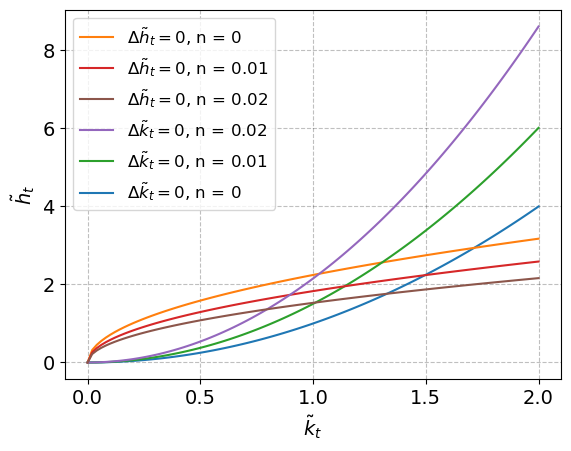

In [188]:
# plot results for different values of n
fig = plt.figure()
ax = fig.add_subplot(1,1,1)


# prepare loop 
label_k = r'$ \Delta \tilde{k}_t = 0$' # latex labels 
label_h = r'$ \Delta \tilde{h}_t = 0$'
n_lst=[0, 0.01, 0.02]

for n_val in n_lst:
    null_k_val = null_k_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sK_val)
    null_h_val = null_h_func(k_tilde_vec,alpha_val,delta_val,g_val, n_val, phi_val, sH_val)
    ax.plot(k_tilde_vec,null_k_val, label = f'{label_k}, n = {n_val}')
    ax.plot(k_tilde_vec,null_h_val, label = f'{label_h}, n = {n_val}')

# set axis
ax.set_xlabel(r'$\tilde{k}_t$',)
ax.set_ylabel(r'$\tilde{h}_t$',)

# customize legend 
# i. specify order 
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,3,5,4,2,0] # 0 is the first label in default legend.
  
# ii. pass handle & labels lists along with order
ax.legend([handles[i] for i in order], [labels[i] for i in order],fontsize="12");

In [189]:
exp = sm.diff(no_change_k,k_tilde)
exp.doit()

ktilde_t**(1 - alpha)*ktilde_t**(alpha - 1)*(ktilde_t**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/phi)*(1 - alpha)/(ktilde_t*phi)